What I learned so far:
- **IOTP will count the bytes in the whole message not the payload**
- **QoS does not alter (<2% variance) reported data usage (when using a stable setup/network)**
- IOTP in Germany behaves strange. Throwing MQTT errno104 connection reset by peer. No other region does that
- paho mqtt client allocated memory for each message ~~published~~ queued
- ~~paho mqtt client has to be disconnected in order to free memory~~ a message has to actually leave the client to free up memory
- sending too many messages(amount varies) in a short time ~~will~~ may cause the iotp to disconnect you
- this may result in a client caught in some never ending loop
- the topic is always part of the message. 

## Dependencies

In [2]:
!pip install cloudant

## Credentials

In [3]:
credentials = {
  'username':'',
  'password':"",
  'host':'',
  'port':'443',
  'url':''
}

In [4]:
# The code was removed by DSX for sharing.

## Util functions

In [5]:
from cloudant import Cloudant
def getDB():
    database = "iotp-cost-calculator"
    client = Cloudant(credentials['username'], credentials['password'], url=credentials['url'], connect=True)
    return client[database]

In [6]:
import numpy
def removeOutliers(input):
    median = numpy.median(numpy.array(input))
    result = [s for s in input if s < 1.5*median and s > median/1.5]
    return result

## Number crunching

### Static overhead calculation

In [16]:
import numpy as np
db = getDB()
documents = db.get_view_result('_design/analysisEnriched', 'analysisEnriched',raw_result=True)['rows']

overall_static_overhead_list = {}
overall_static_overhead_list[0] = []
overall_static_overhead_list[1] = []
overall_static_overhead_list[2] = []

for actual_size in [58,113,527,1058,5323]:
    static_overhead_list = []
    qos_zero_mean = 0
    for qos in range(0,3):
        if(actual_size == 58 and qos ==2): # Filter out this one -> useless data
            continue
        percentage_diff_list = []
        for doc in documents:
            #print(doc)
            if doc['id'] != "_design/analysisEnriched" and doc['value']['qos'] == qos and doc['value']['actual_size'] == actual_size:
                percentage_diff_list.append(doc['value']['percentage_diff'])
        cleanedList = removeOutliers(percentage_diff_list)
        mean = np.mean(cleanedList)
        static_overhead = (actual_size*mean/100)-actual_size
        static_overhead_list.append(static_overhead)
        print("Qos: {}, actual size: {}".format(qos,actual_size))
        #print("Difference in data usages in percent:")
        #print(percentage_diff_list)
        #print("Cleaned:")
        #print(cleanedList)
        print("Cleaned Mean usage diff: {}%".format(mean))
        #print("Standard Deviation: {}".format(np.std(cleanedList)))
        print("Calculated static overhead: {}".format(static_overhead))
        overall_static_overhead_list[qos].append(static_overhead)
    cleaned_static_overhead_list = removeOutliers(static_overhead_list)
    static_overhead_mean = np.mean(cleaned_static_overhead_list)
    #print(static_overhead_list)
    #print(cleaned_static_overhead_list)
    print("Mean static overhead for actual_size {}: {}".format(actual_size,static_overhead_mean))
    print("######################################################")
for qos in range(0,3):
    cleaned_static_overhead_list = {}
    cleaned_static_overhead_list[qos] = removeOutliers(overall_static_overhead_list[qos])
    static_overhead_mean = np.mean(cleaned_static_overhead_list[qos])
    print("Overall static overhead for qos {}: {}".format(qos,static_overhead_mean))

Qos: 0, actual size: 58
Cleaned Mean usage diff: 217.956264138%
Calculated static overhead: 68.4146332
Qos: 1, actual size: 58
Cleaned Mean usage diff: 228.959875%
Calculated static overhead: 74.7967275
Mean static overhead for actual_size 58: 71.60568035
######################################################
Qos: 0, actual size: 113
Cleaned Mean usage diff: 162.281235398%
Calculated static overhead: 70.377796
Qos: 1, actual size: 113
Cleaned Mean usage diff: 182.885357522%
Calculated static overhead: 93.660454
Qos: 2, actual size: 113
Cleaned Mean usage diff: 211.21319823%
Calculated static overhead: 125.670914
Mean static overhead for actual_size 113: 96.5697213333
######################################################
Qos: 0, actual size: 527
Cleaned Mean usage diff: 113.177984364%
Calculated static overhead: 69.4479776
Qos: 1, actual size: 527
Cleaned Mean usage diff: 114.678289374%
Calculated static overhead: 77.354585
Qos: 2, actual size: 527
Cleaned Mean usage diff: 116.31252371

### Difference between qos data usage

In [39]:
import numpy as np
db = getDB()
documents = db.get_view_result('_design/analysisEnriched', 'analysisEnriched',raw_result=True)['rows']

percentage_diff_list_qos_1 = []
percentage_diff_list_qos_2 = []
for actual_size in [58,113,527,1058,5323]:
    mean_list = []
    for qos in range(0,3):
        reported_list = []
        for doc in documents:
            #print(doc)
            if doc['id'] != "_design/analysisEnriched" and doc['value']['qos'] == qos and doc['value']['actual_size'] == actual_size:
                reported = doc['value']['delta_data_usage']
                sending_time = doc['value']['sending_time']
                reported_list.append((sending_time,reported))
        qos_list = []
        for entry in reported_list:
            #print("actual_size: {} qos: {} sending_time: {} reported: {} byte/msg: {}".format(actual_size,qos,entry[0],entry[1],entry[1]/entry[0]))
            qos_list.append(entry[1]/entry[0])
        cleaned_list = removeOutliers(qos_list)
        mean = np.mean(cleaned_list)
        print("actual_size: {} qos: {} mean: {} byte/msg".format(actual_size,qos,mean))
        mean_list.append(mean)
    percentage_diff_list_qos_1.append(mean_list[1]/mean_list[0])
    percentage_diff_list_qos_2.append(mean_list[2]/mean_list[0])
cleaned_list_qos_1 = removeOutliers(percentage_diff_list_qos_1)
mean_qos1 = np.mean(cleaned_list_qos_1)
cleaned_list_qos_2 = removeOutliers(percentage_diff_list_qos_2)
mean_qos2 = np.mean(cleaned_list_qos_2)
print("QoS 1 consumes {}% more bytes than QoS 0".format(mean_qos1))
print("QoS 2 consumes {}% more bytes than QoS 0".format(mean_qos2))

actual_size: 58 qos: 0 mean: 126.2 byte/msg
actual_size: 58 qos: 1 mean: 132.5 byte/msg
actual_size: 58 qos: 2 mean: 315.0 byte/msg
actual_size: 113 qos: 0 mean: 183.0 byte/msg
actual_size: 113 qos: 1 mean: 206.2 byte/msg
actual_size: 113 qos: 2 mean: 238.0 byte/msg
actual_size: 527 qos: 0 mean: 596.4 byte/msg
actual_size: 527 qos: 1 mean: 603.75 byte/msg
actual_size: 527 qos: 2 mean: 612.666666667 byte/msg
actual_size: 1058 qos: 0 mean: 1127.4 byte/msg
actual_size: 1058 qos: 1 mean: 1136.5 byte/msg
actual_size: 1058 qos: 2 mean: 1157.5 byte/msg
actual_size: 5323 qos: 0 mean: 5393.2 byte/msg
actual_size: 5323 qos: 1 mean: 5323.16666667 byte/msg
actual_size: 5323 qos: 2 mean: 5714.0 byte/msg
QoS 1 consumes 1.03682136841% more bytes than QoS 0
QoS 2 consumes 1.10350052934% more bytes than QoS 0


## Visualization

Actual size: 58


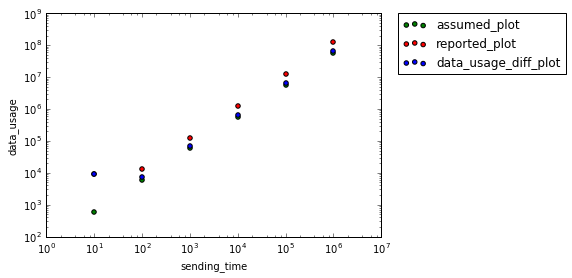

Qos: 0, actual size: 58
Mean delta: 12.409437MB
Reported in MB:
[0.009426, 0.013089, 0.126108, 1.250634, 12.501113, 125.000636]
Assumed in MB:
[0.00058, 0.0058, 0.058, 0.58, 5.8, 58.0]
Diff in MB:
[0.008846, 0.007289, 0.068108, 0.670634, 6.701113, 67.000636]
Difference in data usages in percent:
[1625.1724137931035, 225.67241379310346, 217.42758620689656, 215.62655172413793, 215.53643103448275, 215.5183379310345]
Time took:
[0.002, 0.016, 0.416, 4.4, 81.692, 388.551]


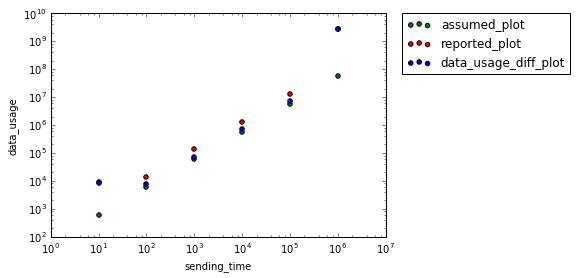

Qos: 1, actual size: 58
Mean delta: 449.832638MB
Reported in MB:
[0.009242, 0.013689, 0.132072, 1.310595, 13.116541, 2748.858071]
Assumed in MB:
[0.00058, 0.0058, 0.058, 0.58, 5.8, 58.0]
Diff in MB:
[0.008662, 0.007889, 0.074072, 0.730595, 7.316541, 2690.858071]
Difference in data usages in percent:
[1593.448275862069, 236.01724137931035, 227.7103448275862, 225.96465517241379, 226.14725862068966, 4739.41046724138]
Time took:
[0.003, 0.021, 0.166, 1.605, 41.596, 2015.62]


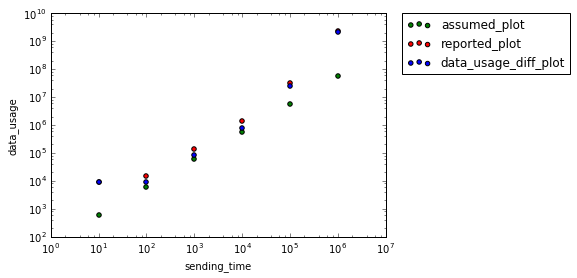

Qos: 2, actual size: 58
Mean delta: 369.848454MB
Reported in MB:
[0.00933, 0.014493, 0.140068, 1.390595, 31.508276, 2250.472345]
Assumed in MB:
[0.00058, 0.0058, 0.058, 0.58, 5.8, 58.0]
Diff in MB:
[0.00875, 0.008693, 0.082068, 0.810595, 25.708276, 2192.472345]
Difference in data usages in percent:
[1608.6206896551723, 249.8793103448276, 241.49655172413793, 239.75775862068966, 543.2461379310345, 3880.1247327586207]
Time took:
[0.007, 0.022, 0.341, 2.491, 28.328, 1205.599]
Actual size: 113


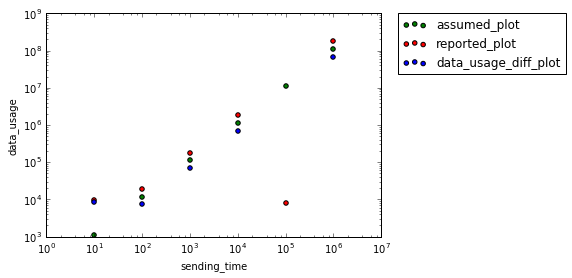

Qos: 0, actual size: 113
Mean delta: 9.580423MB
Reported in MB:
[0.009765, 0.018951, 0.18188, 1.811127, 0.007764, 181.008484]
Assumed in MB:
[0.00113, 0.0113, 0.113, 1.13, 11.3, 113.0]
Diff in MB:
[0.008635, 0.007651, 0.06888, 0.681127, -11.292236, 68.008484]
Difference in data usages in percent:
[864.1592920353983, 167.7079646017699, 160.95575221238937, 160.2767256637168, 0.06870796460176991, 160.18449911504425]
Time took:
[0.003, 0.029, 0.276, 2.698, 31.627, 294.774]


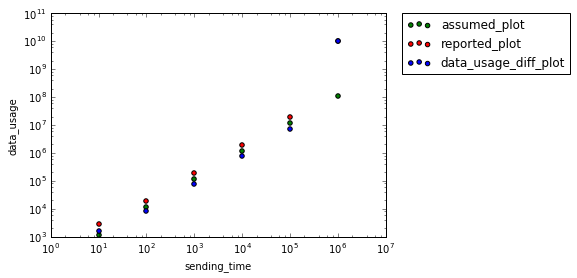

Qos: 1, actual size: 113
Mean delta: 1743.863522MB
Reported in MB:
[0.002756, 0.019586, 0.187646, 1.871126, 18.708367, 10567.947081]
Assumed in MB:
[0.00113, 0.0113, 0.113, 1.13, 11.3, 113.0]
Diff in MB:
[0.001626, 0.008286, 0.074646, 0.741126, 7.408367, 10454.947081]
Difference in data usages in percent:
[243.89380530973452, 173.32743362831857, 166.05840707964603, 165.58637168141593, 165.56076991150442, 9352.16555840708]
Time took:
[0.012, 0.009, 0.165, 2.36, 30.922, 2362.044]


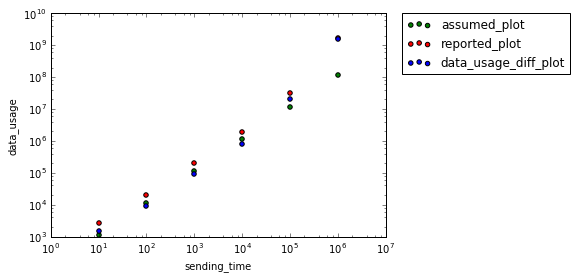

Qos: 2, actual size: 113
Mean delta: 258.222281MB
Reported in MB:
[0.002631, 0.020661, 0.202801, 1.958521, 32.499147, 1640.205359]
Assumed in MB:
[0.00113, 0.0113, 0.113, 1.13, 11.3, 113.0]
Diff in MB:
[0.001501, 0.009361, 0.089801, 0.828521, 21.199147, 1527.205359]
Difference in data usages in percent:
[232.83185840707964, 182.84070796460176, 179.46991150442477, 173.3204424778761, 287.6030707964602, 1451.509167256637]
Time took:
[0.018, 0.012, 0.119, 2.609, 36.819, 1687.649]
Actual size: 527


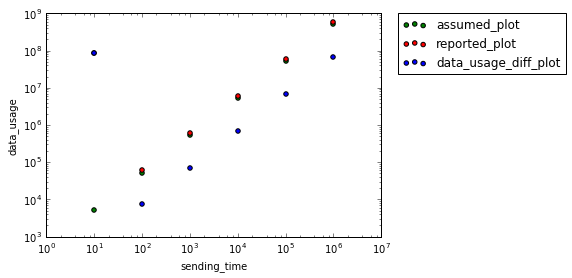

Qos: 0, actual size: 527
Mean delta: 26.528644MB
Reported in MB:
[83.61834, 0.060108, 0.596088, 5.950604, 59.501088, 595.000608]
Assumed in MB:
[0.00527, 0.0527, 0.527, 5.27, 52.7, 527.0]
Diff in MB:
[83.61307, 0.007408, 0.069088, 0.680604, 6.801088, 68.000608]
Difference in data usages in percent:
[1586685.7685009488, 114.05692599620494, 113.10967741935484, 112.91468690702088, 112.90529032258064, 112.90334117647059]
Time took:
[0.002, 0.028, 0.391, 5.009, 41.302, 429.679]


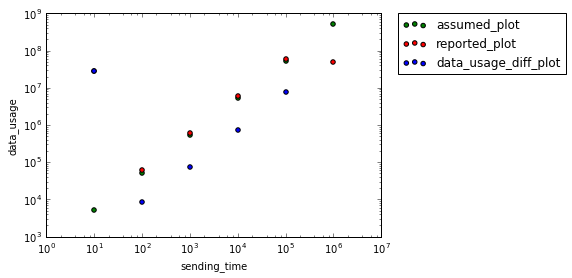

Qos: 1, actual size: 527
Mean delta: -73.199053MB
Reported in MB:
[28.69441, 0.061184, 0.601604, 6.011084, 60.286594, 50.70578]
Assumed in MB:
[0.00527, 0.0527, 0.527, 5.27, 52.7, 527.0]
Diff in MB:
[28.68914, 0.008484, 0.074604, 0.741084, 7.586594, -476.29422]
Difference in data usages in percent:
[544485.9582542694, 116.09867172675521, 114.15635673624288, 114.06231499051233, 114.39581404174574, 9.621590132827324]
Time took:
[0.002, 0.033, 0.283, 3.125, 69.142, 1097.437]


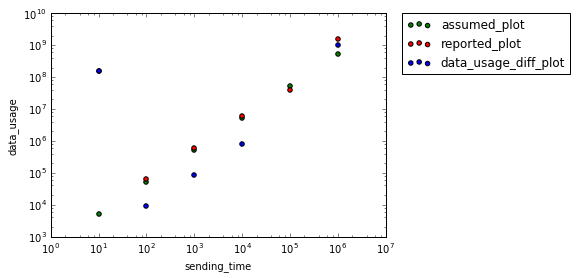

Qos: 2, actual size: 527
Mean delta: 194.167517MB
Reported in MB:
[158.819017, 0.062015, 0.609639, 6.09112, 39.389142, 1545.58914]
Assumed in MB:
[0.00527, 0.0527, 0.527, 5.27, 52.7, 527.0]
Diff in MB:
[158.813747, 0.009315, 0.082639, 0.82112, -13.310858, 1018.58914]
Difference in data usages in percent:
[3013643.586337761, 117.67552182163188, 115.6810246679317, 115.58102466793169, 74.74220493358634, 293.2806717267552]
Time took:
[0.004, 0.023, 0.19, 2.543, 54.468, 1229.825]
Actual size: 1058


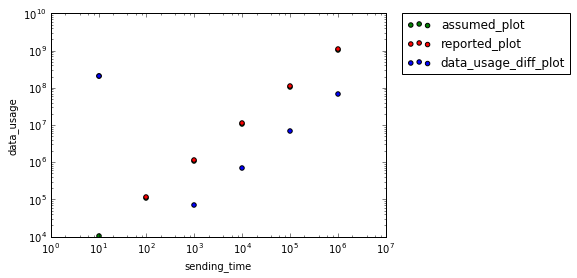

Qos: 0, actual size: 1058
Mean delta: 46.420514MB
Reported in MB:
[202.974876, 0.113208, 1.127088, 11.260608, 112.601084, 1126.0006]
Assumed in MB:
[0.01058, 0.1058, 1.058, 10.58, 105.8, 1058.0]
Diff in MB:
[202.964296, 0.007408, 0.069088, 0.680608, 6.801084, 68.0006]
Difference in data usages in percent:
[1918477.088846881, 107.00189035916824, 106.53005671077504, 106.43296786389413, 106.42824574669187, 106.42727788279772]
Time took:
[0.003, 0.018, 0.263, 3.816, 35.678, 416.912]


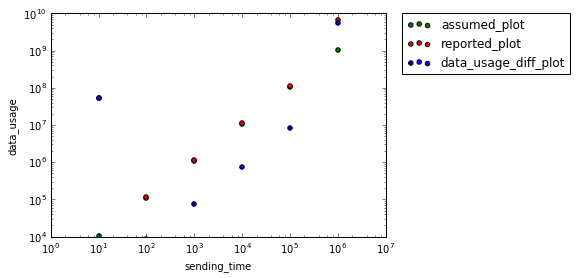

Qos: 1, actual size: 1058
Mean delta: 953.731836MB
Reported in MB:
[54.003019, 0.114313, 1.132638, 11.321119, 113.923504, 6717.450807]
Assumed in MB:
[0.01058, 0.1058, 1.058, 10.58, 105.8, 1058.0]
Diff in MB:
[53.992439, 0.008513, 0.074638, 0.741119, 8.123504, 5659.450807]
Difference in data usages in percent:
[510425.51039697544, 108.04631379962193, 107.05463137996219, 107.0049054820416, 107.67817013232514, 634.9197360113421]
Time took:
[0.021, 0.031, 0.703, 5.038, 88.814, 2756.026]


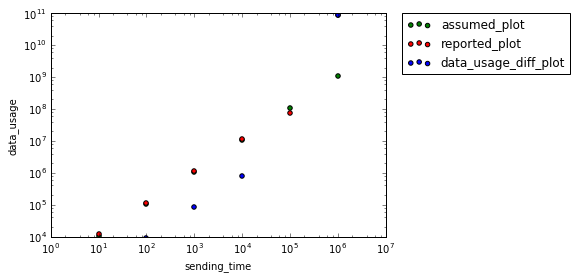

Qos: 2, actual size: 1058
Mean delta: 14863.625533MB
Reported in MB:
[0.012004, 0.115084, 1.140604, 11.401084, 72.509178, 90272.129626]
Assumed in MB:
[0.01058, 0.1058, 1.058, 10.58, 105.8, 1058.0]
Diff in MB:
[0.001424, 0.009284, 0.082604, 0.821084, -33.290822, 89214.129626]
Difference in data usages in percent:
[113.4593572778828, 108.7750472589792, 107.80756143667297, 107.76071833648393, 68.53419470699433, 8532.337393761814]
Time took:
[0.003, 0.011, 0.152, 1.821, 42.553, 1694.818]
Actual size: 5323


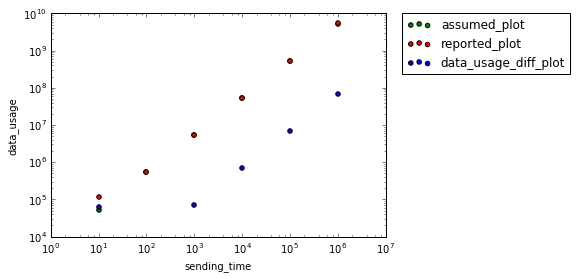

Qos: 0, actual size: 5323
Mean delta: 12.603841MB
Reported in MB:
[0.116841, 0.540216, 5.391641, 53.911119, 539.10064, 5391.001119]
Assumed in MB:
[0.05323, 0.5323, 5.323, 53.23, 532.3, 5323.0]
Diff in MB:
[0.063611, 0.007916, 0.068641, 0.681119, 6.80064, 68.001119]
Difference in data usages in percent:
[219.50216043584444, 101.48713131692655, 101.28951718955476, 101.27957730603043, 101.27759534097314, 101.27749613000188]
Time took:
[0.004, 0.073, 0.443, 4.033, 47.102, 493.456]


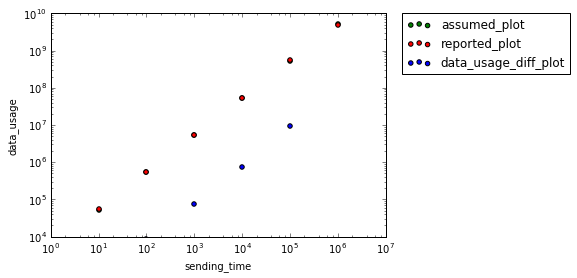

Qos: 1, actual size: 5323
Mean delta: -75.58884MB
Reported in MB:
[0.05462, 0.540822, 5.39765, 53.971154, 541.624124, 4859.317123]
Assumed in MB:
[0.05323, 0.5323, 5.323, 53.23, 532.3, 5323.0]
Diff in MB:
[0.00139, 0.008522, 0.07465, 0.741154, 9.324124, -463.682877]
Difference in data usages in percent:
[102.61130941198573, 101.60097689272966, 101.40240465902687, 101.39236145030998, 101.75166710501597, 91.28906862671425]
Time took:
[0.012, 0.037, 0.303, 4.732, 69.174, 3258.154]


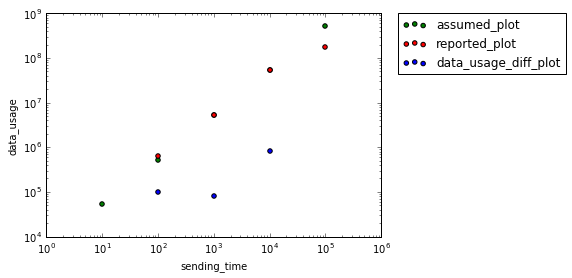

Qos: 2, actual size: 5323
Mean delta: -71.318323MB
Reported in MB:
[0.0, 0.633266, 5.405599, 54.051078, 174.756972]
Assumed in MB:
[0.05323, 0.5323, 5.323, 53.23, 532.3]
Diff in MB:
[-0.05323, 0.100966, 0.082599, 0.821078, -357.543028]
Difference in data usages in percent:
[0, 118.96787525831299, 101.55173774187489, 101.54250986285929, 32.83054142400902]
Time took:
[0.004, 0.034, 0.36, 2.866, 62.594]


In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
db = getDB()
documents = db.get_view_result('_design/analysisEnriched', 'analysisEnriched',raw_result=True)['rows']

for actual_size in [58,113,527,1058,5323]:
    print("Actual size: {}".format(actual_size))
    for qos in range(0,3):
        assumed_list = []
        reported_list = []
        timestamp_list = []
        sending_time_list = []
        data_usage_diff_list = []
        time_took_list = []
        percentage_diff_list = []
        for doc in documents:
            #print(doc)
            if doc['id'] != "_design/analysisEnriched" and doc['value']['qos'] == qos and doc['value']['actual_size'] == actual_size:
                assumed_list.append(doc['value']['assumed_delta_data_usage'])
                reported_list.append(doc['value']['delta_data_usage'])
                data_usage_diff_list.append(doc['value']['data_usage_diff'])
                timestamp_list.append(doc['value']['storage_timestamp'])
                time_took_list.append(doc['value']['time_took'])
                sending_time_list.append(doc['value']['sending_time'])
                percentage_diff_list.append(doc['value']['percentage_diff'])
        assumed_plot = plt.scatter(sending_time_list,assumed_list,c="green",label="assumed_delta_data_usage")
        reported_plot = plt.scatter(sending_time_list,reported_list,c="red",label="reported_delta_data_usage")
        data_usage_diff_plot = plt.scatter(sending_time_list,data_usage_diff_list,c="blue",label="data_usage_diff")
        plt.xlabel("sending_time")
        plt.ylabel("data_usage")
        plt.legend((assumed_plot,reported_plot,data_usage_diff_plot),("assumed_plot","reported_plot","data_usage_diff_plot"),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.xscale('log')
        plt.yscale('log')
        plt.show()
        if len(data_usage_diff_list) > 0:    
            mean_delta = sum(data_usage_diff_list)/len(data_usage_diff_list)
        else:
            mean_delta = 0
        print("Qos: {}, actual size: {}".format(qos,actual_size))
        print("Mean delta: {}MB".format(mean_delta/1000000.0))
        print("Reported in MB:")
        print(map(lambda x: x/1000000.0,reported_list))
        print("Assumed in MB:")
        print(map(lambda x: x/1000000.0,assumed_list))
        print("Diff in MB:")
        print(map(lambda x: x/1000000.0,data_usage_diff_list))
        print("Difference in data usages in percent:")
        print(percentage_diff_list)
        print("Time took:")
        print(time_took_list)